In [1]:
import torch
import torch.nn as nn
import torchvision as tv
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as Func


In [2]:
logostxt=open("D:/Downloads/datasets/mini_logo_good/spisok.txt")
logos_list=logostxt.read().split("\n")
#logos_list=['Burger King','KFC','McDonalds','Other','Starbucks','Subway']
logos_list.sort()
CountOfClasses=len(logos_list)
logos_list

['',
 'ABLE',
 'AC',
 'ACID',
 'AFernandez',
 'ALCO',
 'AND1',
 'Acorn',
 'AdanyEva',
 'Addidas',
 'Advent',
 'Alliance',
 'AlmostSkateboards',
 'Always',
 'Amador',
 'Amoco',
 'Amsterdam',
 'Anchorage',
 'Animal',
 'Ankara',
 'Annapurna',
 'getListOfDir.bat',
 'spisok.txt']

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device is',device)

device is cpu


In [4]:
path = 'D:/Downloads/datasets/mini_logo_good/train'

In [5]:
transforms=tv.transforms.Compose([
    tv.transforms.Resize((70,70)),
    tv.transforms.ToTensor()
    
])

In [6]:
from matplotlib.transforms import Transform
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)

In [7]:
dataloader=torch.utils.data.DataLoader(dataset,batch_size=16,shuffle=True,num_workers=4)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608]],

        [[0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         ...,
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608]],

        [[0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
         [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
         [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0

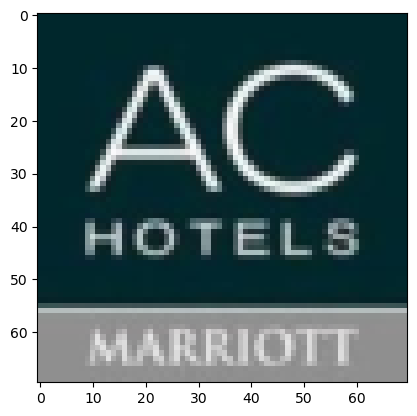

In [8]:
plt.imshow(dataset[118][0].numpy().transpose((1,2,0)))
print(dataset[118])
#print(dataset[50][0].numpy().transpose((1,2,0)).shape)
#print(dataset[50][0].shape)
#m=nn.Conv2d(3,32,kernel_size=3,padding=0)
#m=nn.AdaptiveAvgPool2d((1,1))
#print(m(dataset[50][0]).shape) 
#plt.imshow(m(dataset[50][0]).numpy().transpose((1,2,0)))
#print(dataset[50])

In [9]:
class CNA(nn.Module):
  def __init__(self,in_ch=32,out_ch=32):
    super().__init__()
    self.conv=nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1)
    self.norm=nn.BatchNorm2d(out_ch)
    self.act=nn.ReLU()

  def forward(self,x):
    out=self.conv(x)
    out=self.norm(out)
    out=self.act(out)
    return out
net=CNA()
net=net.to(device)

In [10]:
class MyConvModel(nn.Module):
  def __init__(self, base_ch=64):
    super().__init__()
    cna1_1=CNA(3,base_ch) 
    cna1_2=CNA(base_ch,base_ch) 
    cna2_1=CNA(base_ch,2*base_ch)
    cna2_2=CNA(2*base_ch,2*base_ch)
    cna3_1=CNA(2*base_ch,4*base_ch)
    cna3_2=CNA(4*base_ch,4*base_ch)
    cna4_1=CNA(4*base_ch,8*base_ch)
    cna4_2=CNA(8*base_ch,8*base_ch)
    cna5_1=CNA(8*base_ch,16*base_ch)
    cna6_1=CNA(16*base_ch,32*base_ch)
    
    Linear=nn.Linear(32*base_ch,CountOfClasses)
    maxpool=nn.MaxPool2d(2,2)
    avgpool=nn.AdaptiveAvgPool2d((1,1))
    flatten=nn.Flatten()
    self.model = nn.Sequential(
          cna1_1,cna1_2,maxpool,# (16,3,60,60)-> (16,32,30,30)
          cna2_1,cna2_2,maxpool,#(16,32,30,30)->(16,64,15,15)
          cna3_1,cna3_2,maxpool,
          cna4_1,cna4_2,maxpool,
          cna5_1,maxpool,
          cna6_1,avgpool,
          flatten,Linear
    )
  def forward(self,x):
    return self.model(x)
net=MyConvModel()
net=net.to(device)

In [11]:
loss_fn = nn.CrossEntropyLoss()
#loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(net.parameters(),lr=1e-4, betas=(0.9, 0.999))
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)
print(count_parameters(net))

28338519


In [12]:
def get_accuracy(pred, label):
    answer = pred.detach().numpy().argmax(1) == label.numpy().argmax(1) 
    return answer.mean()

In [13]:
epochs=10
for epoch in range(epochs):
    loss_val=0
    acc_val=0

    for sample in dataloader:
        img,label = sample

        label = label.to(device)
        label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
        img = img.to(device)
        
        optimizer.zero_grad()
       
        
        pred = net (img)

        loss = loss_fn(pred, label)
        loss.backward()

        optimizer.step()
        
        loss_val+=loss.item()
        acc_val += get_accuracy(pred.cpu(), label.cpu())

    loss_val /= len(dataloader)
    acc_val /= len(dataloader)
    print("epoch=",epoch,"loss=",loss_val ,"accruracy=",acc_val)

epoch= 0 loss= 2.6775517904240154 accruracy= 0.20040760869565216
epoch= 1 loss= 2.306934370942738 accruracy= 0.3195199275362319
epoch= 2 loss= 2.061303699794023 accruracy= 0.3847373188405797
epoch= 3 loss= 1.7280874304149463 accruracy= 0.49184782608695654
epoch= 4 loss= 1.3744135123232137 accruracy= 0.592391304347826
epoch= 5 loss= 1.0017770088237266 accruracy= 0.7214673913043478
epoch= 6 loss= 0.599314702593762 accruracy= 0.8353713768115942
epoch= 7 loss= 0.33646456516631273 accruracy= 0.9155344202898551
epoch= 8 loss= 0.1863026168278378 accruracy= 0.9626358695652174


KeyboardInterrupt: 

In [54]:
torch.save(net.state_dict(), 'D:\\myprogect\\pytorch\\logo classifier\\weights')

In [ ]:
model = MyConvModel()
model.load_state_dict(torch.load('D:\\myprogect\\pytorch\\logo classifier\\weights'))
model.eval()

Test for one image

In [56]:
path="D:/Downloads/datasets/mini_logo_good/test1/11/37jpg.jpg"
img=Image.open(path)
tensorImg=transforms(img)
batchImg=torch.unsqueeze(tensorImg,0)
out=net(batchImg)
print(out.shape)
print(out)
# dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
# #print(dataset[0])
# testloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True)
# for sample in testloader:
#   img,label = sample
#   img=img.to(device)
#   pred=net(img)
  
#   pred=max(pred).tolist()
#   print(pred)
#   print(pred.index(max(pred)))
#   print(max(pred))
#   print(logos_list[ pred.index(max(pred))])

torch.Size([1, 23])
tensor([[-8.3241e-01,  2.9545e-02,  1.9700e-02,  2.3875e-01,  8.7395e-02,
         -2.7458e-01, -7.4740e-01, -1.9076e+00, -4.2986e-01, -9.0156e-02,
          2.4768e-03,  3.0197e-01, -3.4586e-01,  4.3189e-01, -9.1949e-01,
          4.1154e-02,  4.9979e-01,  6.6987e-02,  6.4191e-01,  2.4465e-01,
         -5.5834e+00, -5.2206e+00, -5.5266e+00]], grad_fn=<AddmmBackward0>)


test for test dataset

In [15]:
path = 'D:/Downloads/datasets/mini_logo_good/test'
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=16,shuffle=True,num_workers=4)
loss_val=0
acc_val=0
for sample in dataloader:
    img,label = sample

    label = label.to(device)
    label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
    img = img.to(device) 
    pred = net (img)

    loss = loss_fn(pred, label)
         
    loss_val+=loss.item()
    acc_val += get_accuracy(pred.cpu(), label.cpu())

loss_val /= len(dataloader)
acc_val /= len(dataloader)
print("loss=",loss_val ,"accruracy=",acc_val)

loss= 0.09780351103593905 accruracy= 0.98125
